# 0: Importing 

In [1]:
# common imports
import os
import numpy as np
import random
# Visualization
import datetime 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# TensorFlow imports
# may differs from version to versions

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing import image

In [2]:
# check version of tensorflow
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))  # check to see if we using GPU
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available


using my local GPU: Nvidia GTX 3070 8GB

# 1. Dataset

In [3]:
train_folder = 'train_images' # filepath on local machine
test_folder = 'test_images' # filepath on local machine
img_height, img_width = 224, 224 # size of images
num_classes = 10 # 10 signs


batch_size = 16

AUTOTUNE = tf.data.AUTOTUNE

In [4]:
# Training and validation sets
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_folder,
    validation_split= 0.2, # 20% for the validation,
    subset='training',
    seed=42, # for reproducability 
    image_size=(img_height, img_width), 
    label_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    train_folder,
    validation_split= 0.2, # 20% for the validation,
    subset='validation',
    seed=42, # for reproducability
    image_size=(img_height, img_width),
    label_mode = 'categorical',
    batch_size = batch_size,
    shuffle=True
)

Found 108 files belonging to 10 classes.
Using 87 files for training.
Found 108 files belonging to 10 classes.
Using 21 files for validation.


In [5]:
# test set
test_ds = keras.preprocessing.image_dataset_from_directory(
    test_folder,
    image_size=(img_height, img_width),
    label_mode = 'categorical',
    shuffle=False
)

Found 30 files belonging to 10 classes.


In [6]:
class_names = test_ds.class_names
class_names

['Hey',
 'How are you',
 'Name',
 'Nice to meet you',
 'No',
 'Run',
 'Sit',
 'Swim',
 'What',
 'Yes']

## Build the Model (ResNet50)

We will call the keras api to get the resnet50 model

In [7]:
base_model = keras.applications.ResNet50(weights='imagenet',
                                         include_top=False,  # without dense part of the network
                                         input_shape=(img_height, img_width, 3))

In [8]:
# Set layers to non-trainable
# freeze the layers
for layer in base_model.layers:
    layer.trainable = False

In [9]:
# Add custom layers on top of ResNet
global_avg_pooling = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(num_classes, activation='softmax')(global_avg_pooling) # 10 classes = 10 units

sign_classifier = keras.models.Model(inputs=base_model.input,
                                     outputs=output,
                                     name='ResNet50')

sign_classifier.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [10]:
# Modelchecekpoint to save model in case of interrupting the learning process
ckp = ModelCheckpoint("models/sign_classifier.h5",
                        monitor='val_loss',
                        mode='min',
                        save_best_only=True,
                        verbose=1)

# Earlystopping to find best model with a large number of epochs
earlystop = EarlyStopping(monitor='val_loss',
                            restore_best_weights=True,
                            patience=3, # num of epochs with no improvement, after that, training will stop
                            verbose=1)

callbacks = [earlystop, ckp]

In [11]:
sign_classifier.compile(loss='categorical_crossentropy',
                        optimizer=keras.optimizers.Adam(learning_rate=0.01),
                        metrics=['accuracy'])

# Training

In [12]:
epochs = 50

history = sign_classifier.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds
)

sign_classifier.save('sign_classifier.h5')

Epoch 1/50
6/6 [==============================] - ETA: 0s - loss: 10.8261 - accuracy: 0.1954
Epoch 1: val_loss improved from inf to 8.82717, saving model to models\sign_classifier.h5
6/6 [==============================] - 7s 365ms/step - loss: 10.8261 - accuracy: 0.1954 - val_loss: 8.8272 - val_accuracy: 0.3810
Epoch 2/50
5/6 [========================>.....] - ETA: 0s - loss: 5.8868 - accuracy: 0.4750
Epoch 2: val_loss improved from 8.82717 to 7.66923, saving model to models\sign_classifier.h5
6/6 [==============================] - 1s 130ms/step - loss: 5.8079 - accuracy: 0.4943 - val_loss: 7.6692 - val_accuracy: 0.2381
Epoch 3/50
5/6 [========================>.....] - ETA: 0s - loss: 5.1416 - accuracy: 0.5875
Epoch 3: val_loss improved from 7.66923 to 3.71918, saving model to models\sign_classifier.h5
6/6 [==============================] - 1s 119ms/step - loss: 5.0164 - accuracy: 0.5977 - val_loss: 3.7192 - val_accuracy: 0.5714
Epoch 4/50
5/6 [========================>.....] - ETA: 0s

In [18]:
def visualize(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('ResNet model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

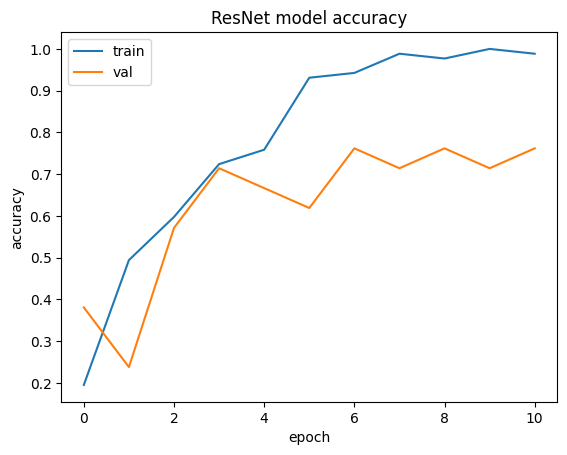

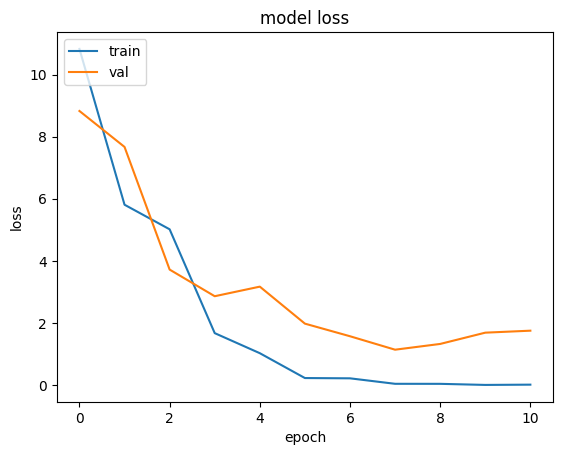

In [19]:
visualize(history)

# Testing

In [33]:
def load_img(filename, img_shape=224, scale=True):
    """Read in an image
        Return:
        image to tensor and reshape to 250,250,3
    """
    
    # read in image
    img = tf.io.read_file(filename)
    # decode it into a tensor
    img = tf.io.decode_image(img)
    # resize the img
    img = tf.image.resize(img, [img_shape, img_shape])
    if scale:
        # rescale the image (all values between 0 and 1)
        return img/255.
    else:
        return img

def predict(dataset, model):
    plt.figure(figsize=(17,10))
    for i in range(3):
        # choose a random img from a random class
        class_name = random.choice(dataset.class_names)
        filename = random.choice(os.listdir('test_images/' + class_name))
        filepath = 'test_images/' + class_name + '/' + filename

        # load the image and make prediction
        img = load_img(filepath, scale=False)
        pred_prob = model.predict(tf.expand_dims(img, axis=0)) ## model accepts tensors of shape [None, shape, shape,3]]
        pred_class = dataset.class_names[pred_prob.argmax()] # find the indices of highest prob

        # plot the img
        plt.subplot(1, 3, i+1)
        plt.imshow(img/255.)
        if class_name == pred_class:
            title_color = 'g'
        else:
            title_color = 'r'
        plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
        plt.axis(False)
    plt.show()
        
def n_predict(dataset, model):
    for i in range(10):
        predict(dataset, model)

In [34]:
model_name = 'sign_classifier.h5'
sign_classifier = keras.models.load_model(model_name)

1/1 [==============================] - 0s 20ms/step


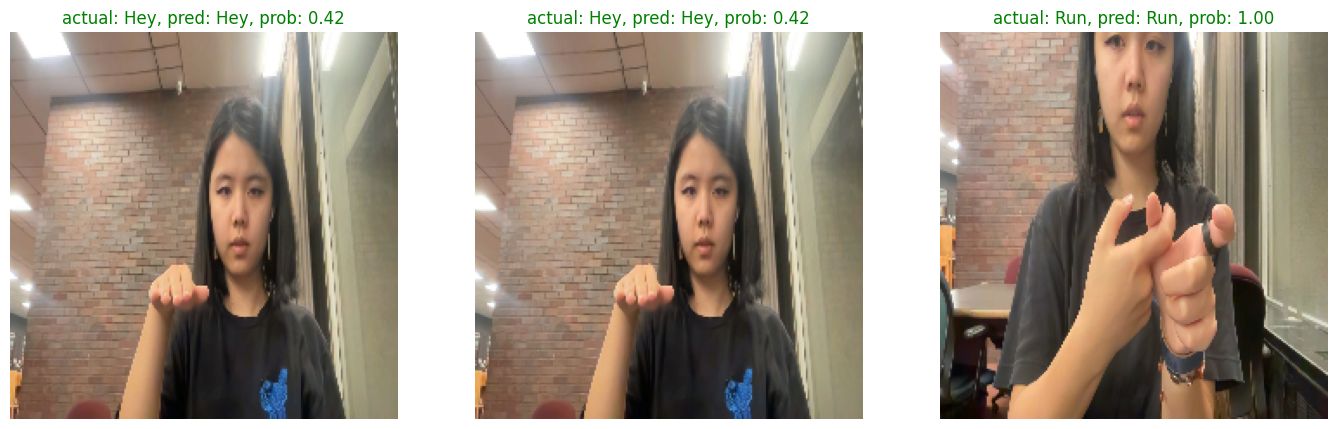

1/1 [==============================] - 0s 21ms/step


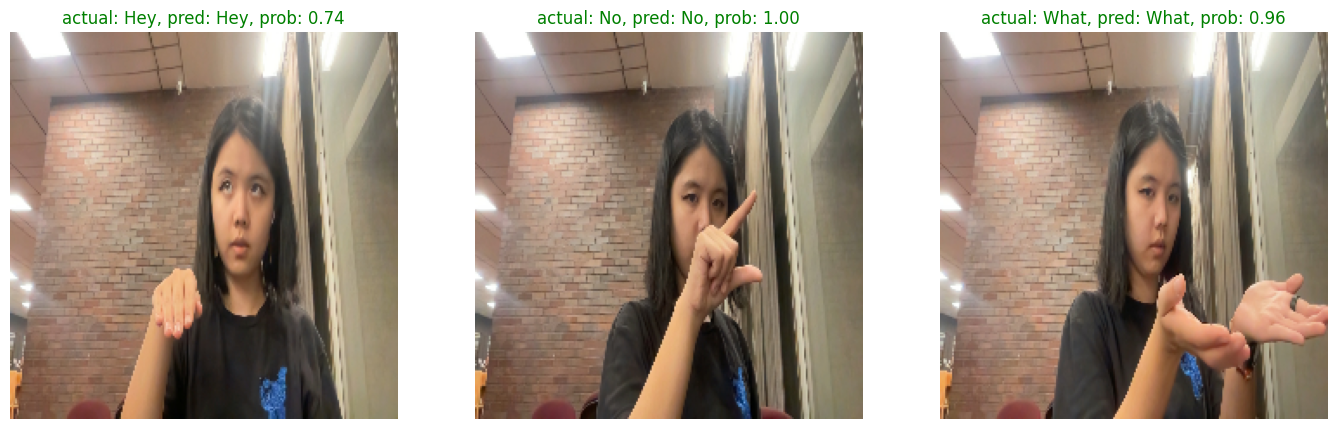

1/1 [==============================] - 0s 22ms/step


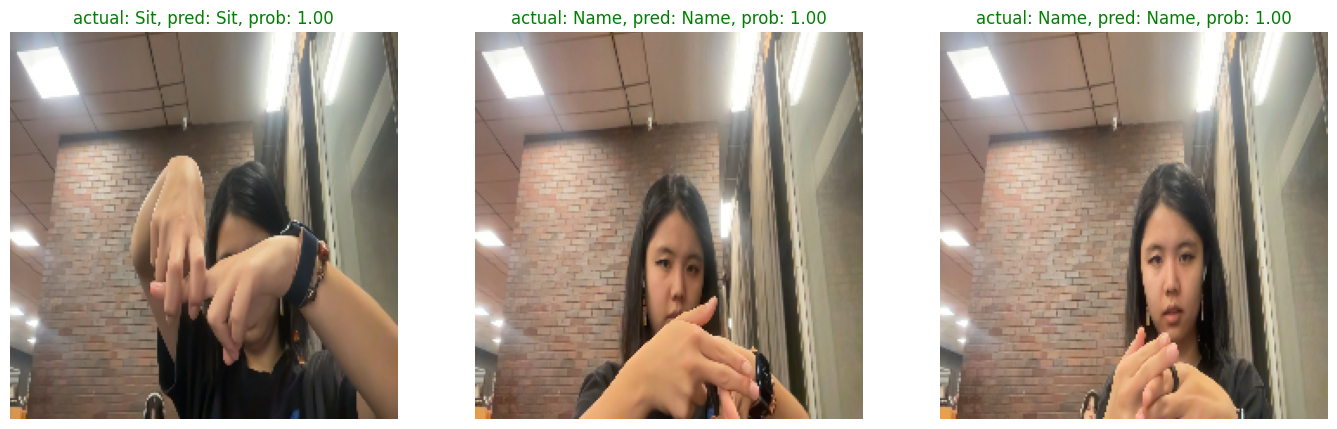

1/1 [==============================] - 0s 20ms/step


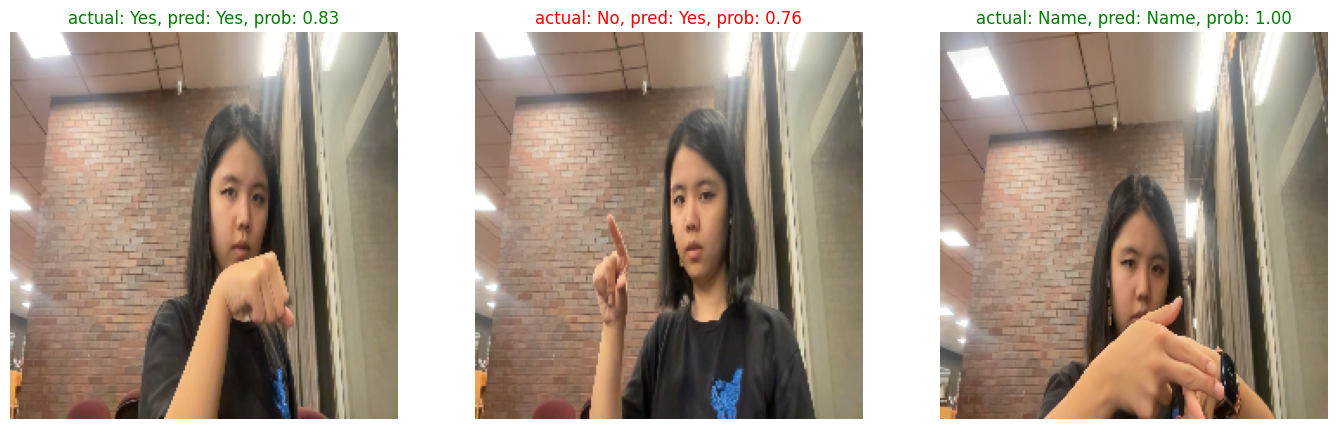

1/1 [==============================] - 0s 22ms/step


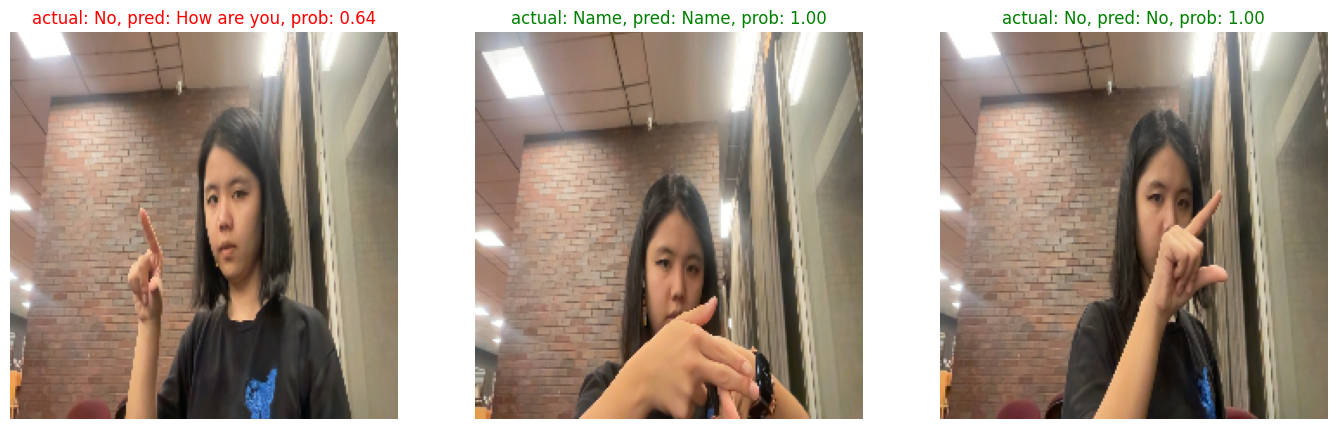

1/1 [==============================] - 0s 21ms/step


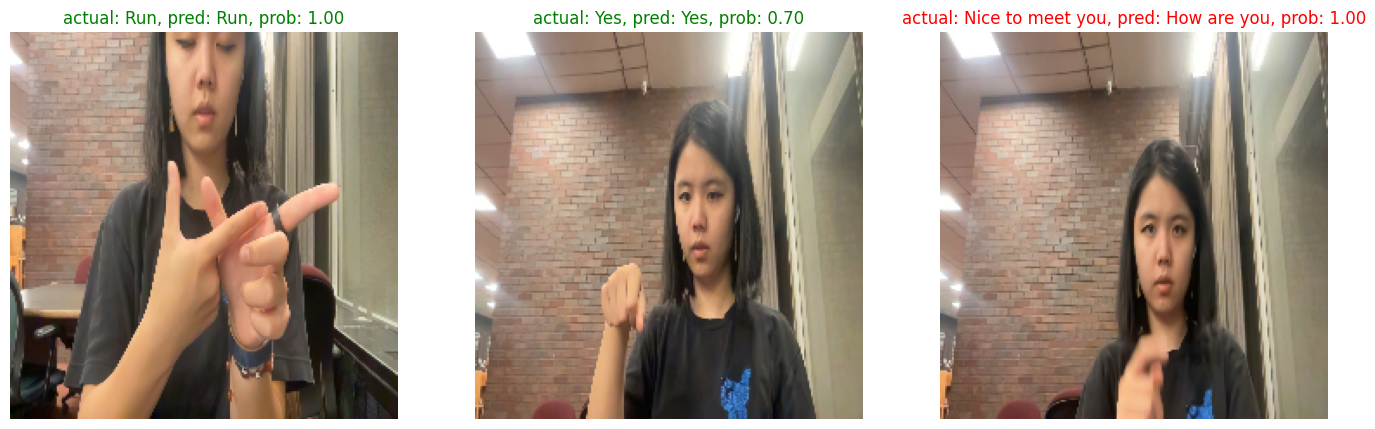

1/1 [==============================] - 0s 22ms/step


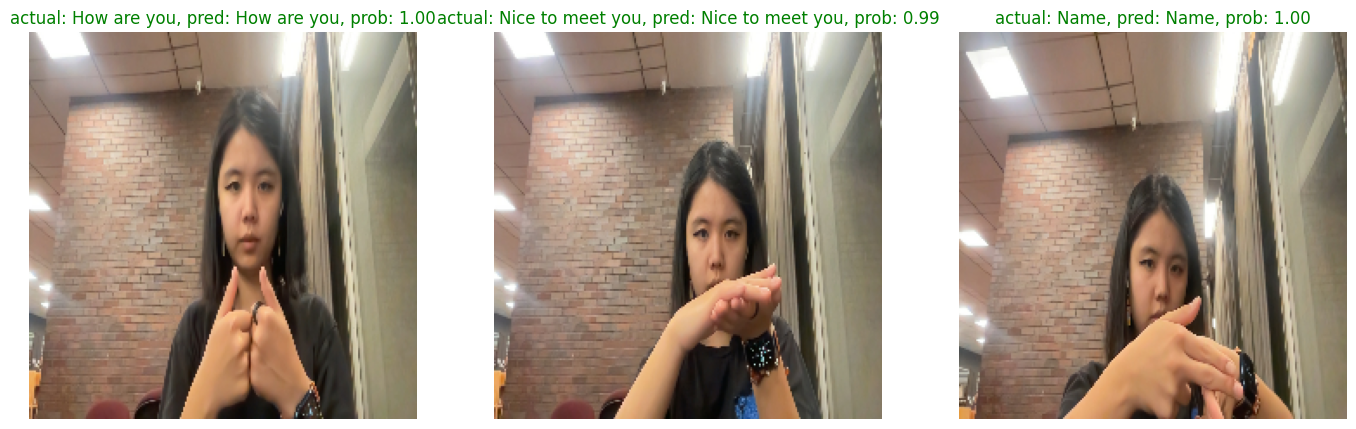

1/1 [==============================] - 0s 20ms/step


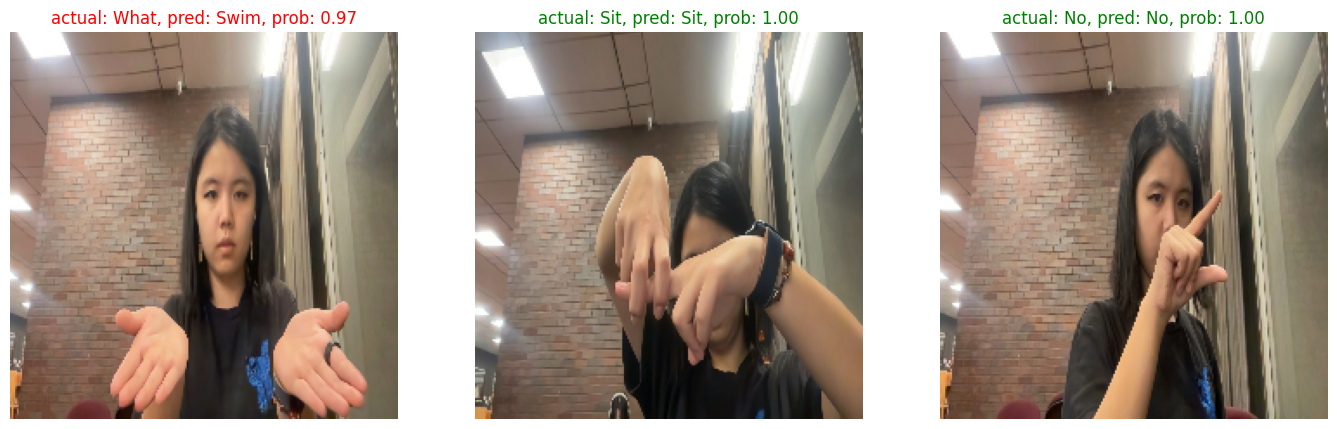

1/1 [==============================] - 0s 20ms/step


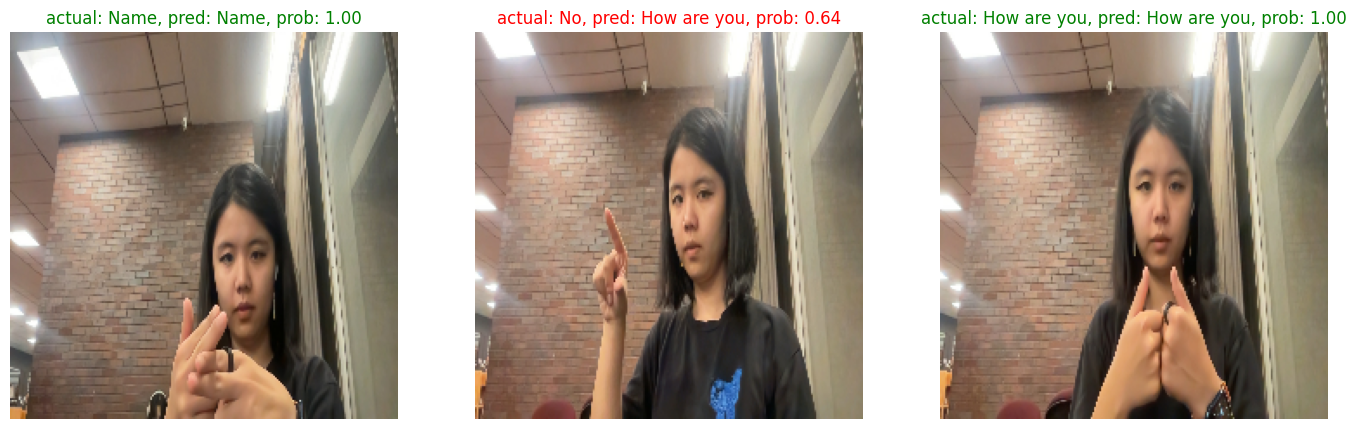

1/1 [==============================] - 0s 21ms/step


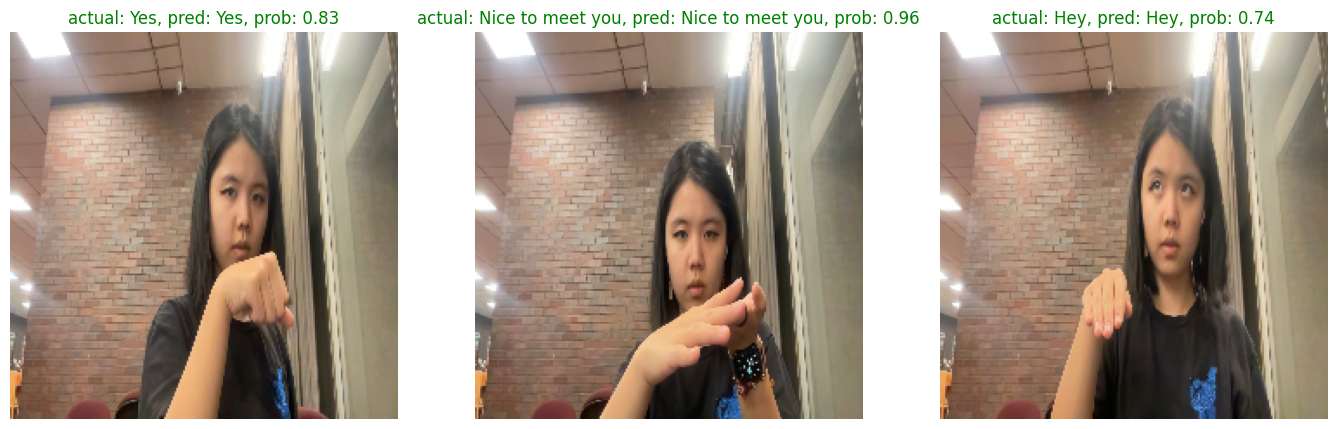

In [35]:
n_predict(test_ds, sign_classifier)

In [36]:
sign_classifier.evaluate(test_ds)

1/1 [==============================] - 1s 1s/step - loss: 1.6906 - accuracy: 0.7667


[1.6906291246414185, 0.7666666507720947]